In [1]:
# Colab에 Khaiii 설치

import os
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python


Cloning into 'khaiii'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 957 (delta 25), reused 49 (delta 19), pack-reused 877
Receiving objects: 100% (957/957), 33.03 MiB | 24.78 MiB/s, done.
Resolving deltas: 100% (383/383), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-

In [4]:
# src에 있는 preanal.manual 파일 dir로 옮기는 Code

import shutil

filename = "preanal.manual"
src = '/content/'
dir = '/content/khaiii/rsc/src/'

shutil.move(src+filename, dir+filename)

'/content/khaiii/rsc/src/preanal.manual'

In [5]:
# Khaiii 사용자 사전 추가
''' 
** Khaiii 사용자 사전 추가를 참고  **
'''

!cd /content/khaiii/rsc
!mkdir -p /content/build/share/khaiii
!PYTHONPATH=/content/khaiii/src/main/python /content/khaiii/rsc/bin/compile_preanal.py --rsc-src=/content/khaiii/rsc/src --rsc-dir=/content/build/share/khaiii

INFO:root:preanal.auto
INFO:root:preanal.manual
ERROR:root:preanal.manual:24: [DUPLICATED] with "식빵	식빵/NNG": "식빵*	식빵/NNP"
ERROR:root:preanal.manual:29: [DUPLICATED] with "커피	커피/NNG": "커피*	커피/NNP"
ERROR:root:preanal.manual:51: [DUPLICATED] with "인절미	인절미/NNG": "인절미*	인절미/NNP"
ERROR:root:preanal.manual:52: [DUPLICATED] with "딸기	딸기/NNG": "딸기*	딸기/NNP"
ERROR:root:preanal.manual:57: [DUPLICATED] with "음료	음료/NNG": "음료*	음료/NNP"
ERROR:root:preanal.manual:125: [DUPLICATED] with "케이크	케이크/NNG": "케이크*	케이크/NNP"
ERROR:root:preanal.manual:145: [DUPLICATED] with "우유	우유/NNG": "우유*	우유/NNP"
ERROR:root:preanal.manual:165: [DUPLICATED] with "주문	주문/NNG": "주문*	주문/NNP"
ERROR:root:preanal.manual:166: [DUPLICATED] with "제작	제작/NNG": "제작*	제작/NNP"
ERROR:root:preanal.manual:181: [DUPLICATED] with "파인애플*	파인애플/NNG": "파인애플*	파인애플/NNP"
ERROR:root:preanal.manual:229: [DUPLICATED] with "레몬	레몬/NNG": "레몬*	레몬/NNP"
ERROR:root:preanal.manual:262: [DUPLICATED] with "초콜릿	초콜릿/NNG": "초콜릿*	초콜릿/NNP"
ERROR:root:preanal.manual:311: [DUPL

## Gensim Topic Modeling


In [6]:
import pandas as pd


data = pd.read_csv('/content/final_input.csv', encoding='utf-8').drop(['Unnamed: 0'], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Nickname  1566 non-null   object
 1   Review    1566 non-null   object
dtypes: object(2)
memory usage: 24.6+ KB


# Gensim LDA를 위한 데이터 전처리
## Experiment 1) Khaiii에서 명사, 어근만 추출해 Tokenizing




In [8]:
from khaiii import KhaiiiApi
api = KhaiiiApi(rsc_dir="/content/build/share/khaiii")

n_tags = ['NNG', 'NNP', 'NNB', 'XR']#, 'VV', "VA"] # 동사도 넣고 싶으면 추가

'''
input : 추출할 Review의 list ;
output : n_tags의 tag와 일치하는 text list ; 
'''

def extract_corpus_khaiii(texts):
    extract_corpus = []
    for line in texts:
      if str(line) != 'nan':
        nouns = []

        for word in api.analyze(str(line)):
          for morphs in word.morphs:
            if morphs.tag in n_tags:
              if len(morphs.lex) > 1:
                nouns.append(morphs.lex)
              else:
                continue

        extract_corpus.append(nouns)

    return extract_corpus
  

In [9]:
# 네이버 영수증 리뷰, 인스타 리뷰에서 명사, 어근을 추출
khaiii_xr = extract_corpus_khaiii(data['Review']) 

#khaiii_all = extract_corpus_khaiii(data['Review']) # 명사, 동사, 형용사, 어근 모두 추출

In [10]:
# 추출 전 데이터와 비교

print(len(data), len(khaiii_xr))
#print(len(data), len(khaiii_all))

1566 1566


In [11]:
import gensim
from gensim.utils import simple_preprocess
# Build the bigram and trigram models
bigram = gensim.models.Phrases(khaiii_xr, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[khaiii_xr], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [177]:
# remove Stopwords, make bigram, trigram function

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
# Stop words 제거 및 trigram 만들기

#khaiii_xr = remove_stopwords(khaiii_xr)

khaiii_xr = make_trigrams(khaiii_xr)

In [14]:
# countvectorize를 위한 역토큰화 진행
'''
input : n_tags만 뽑힌 token list
 Ex. ['얼그레이', '마카롱', '맛']

output : 역토큰화된 detoken list
 Ex. ['얼그레이 마카롱 맛']
'''
def detokenize(token_list):
  detokenized_doc = []
  for i in range(len(token_list)):
    if token_list[i] != []:
      t = ' '.join(token_list[i])

      detokenized_doc.append(t)
  return detokenized_doc
    #detokenized_doc.append([data['Nickname'][i], t]) -> 옆에 닉네임 붙여서 내보낼거면 활성화

In [15]:
# bigram, trigram으로 합쳐진 단어는 _로 합쳐지기 때문에 _를 제거하고 합쳐줌

for i in range(len(khaiii_xr)):
  for j in range(len(khaiii_xr[i])):
    khaiii_xr[i][j] = khaiii_xr[i][j].replace("_", "")

In [16]:
# trigram으로 형성된 토큰 역토큰화

detoken_xr = detokenize(khaiii_xr)

## Using Gensim

In [19]:
# install gensim

!pip install gensim


In [ ]:
# import package

from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus


In [148]:

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora


# Warning 무시
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=Warning, module='gensim')
warnings.filterwarnings('ignore')

* **num_topics**: 최종 분석의 주제 수
* **passes**: 총 훈련 과정의 수. 신경망 학습에서 에포크와 같다
* **iteration** : 각 문서에 대해 업데이트를 반복하는 횟수
* **random_state**: 재현 가능한 결과를 위해 임의의 숫자를 설정한다.

### 최적의 number of words 찾기
* 지표 : Coherence

In [206]:
# number_of_words를 찾기 위한 함수

def compete_number_of_words(detoken_data, token_data, min_num, max_num, step, random_state=None):

  '''
  number_of_words를 찾기 위한 함수 

  Parameters :
  -------------
  detoken_data : list 형태의 역토큰화된 데이터
  token_data : coherence 값을 계산하기 위한 token_data
  min_num : number of words range의 최솟값 min_num부터 시작
  max_num : number of words range의 최댓값 max_num까지 찾음
  step : min_num ~ max_num 까지 가기 위해 step을 얼마나 갈것인지
  random_state : 재현성을 주기 위해 설정, default = None

  Output :
  -------------
  coherence_value : Num of Words와 그에 따른 Coherence Value가 있는 DataFrame 반환
  
  '''

  coherence_value = pd.DataFrame(columns=['Num of Words', 'Perplexity Value','Coherence Value'])

  i = 0

  for feature in range(min_num, max_num, step):
    print("{} 번째, {}'th of words training".format(i+1, feature))

    vectorizer = CountVectorizer(max_features=feature) # CountVectorizer 생성
    cv = vectorizer.fit_transform(detoken_data) # fit and transform

    dictionary = corpora.Dictionary([vectorizer.get_feature_names()])

    corpus = Sparse2Corpus(cv.T)

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, random_state=random_state)

    coherence_lda = CoherenceModel(model=lda_model, texts=token_data, dictionary=dictionary, coherence='c_v')

    coherence_value.loc[i] = [feature, lda_model.log_perplexity(corpus),coherence_lda.get_coherence()]
    i += 1

  return coherence_value

In [ ]:
# 1000 ~ 32000까지 1000 step씩 건너며 coherence value 계산

compete_num_words = compete_number_of_words(detoken_xr, khaiii_xr, 1000, 32000, 1000, random_state=42)

In [31]:
# 그래프 시각화를 위한 package import

%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

# 글씨 크기 조정
plt.rc('font', size=14)

NameError: ignored

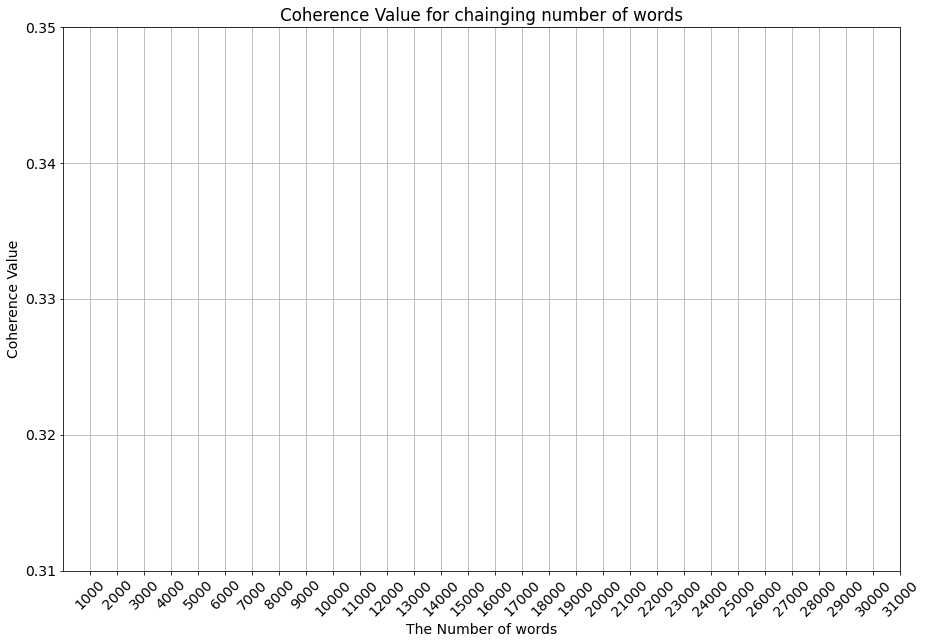

In [32]:
# Number of words의 변화에 따른 coherence value 그래프 

plt.figure(figsize=(15, 10))
plt.xlabel('The Number of words')
plt.ylabel('Coherence Value')
plt.xticks(np.arange(1000, 32000, 1000), rotation=45)
plt.yticks(np.arange(0.31, 0.36, 0.01))
plt.ylim(0.31, 0.35)
plt.grid(True)
plt.title("Coherence Value for chainging number of words")
plt.plot(compete_num_words['Num of Words'], compete_num_words['Coherence Value'])
plt.scatter(compete_num_words['Num of Words'], compete_num_words['Coherence Value'])
plt.show()


In [ ]:
# Number of Words에 따른 abs(Log Perplexity) 값 그래프

plt.figure(figsize=(15, 10))
plt.xlabel('The Number of words')
plt.ylabel('Coherence Value')
plt.xticks(np.arange(1000, 32000, 1000), rotation=45)
plt.grid(True)
plt.title("abs(Peplexity Value) for chainging number of words")
plt.plot(compete_num_words['Num of Words'], abs(compete_num_words['Perplexity Value']), 'r')
plt.scatter(compete_num_words['Num of Words'], abs(compete_num_words['Perplexity Value']), c='r')
plt.show()


In [ ]:
# 위의 두 개의 그래프 합치기

fig, ax1 = plt.subplots(figsize=(10, 10))

x = np.arange(1000, 32000, 1000)
y1 = compete_num_words['Coherence Value']
y2 = abs(compete_num_words['Perplexity Value'])

ax1.set_xlabel('Number Of Words')
ax1.set_ylabel('Coherence Value', color='blue')
ax1.set_ylim(0.31, 0.35)
ax1.plot(x, y1, c='b')
ax1.scatter(x, y1, c='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  
ax2.set_ylabel('Perplexity Value', color='red')  
ax2.plot(x, y2, c='r')
ax2.scatter(x, y2, c='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(['Coherence Value','c_v', 'abs(Perplexity Value', 'p_v'])
fig.tight_layout()

plt.grid()
plt.show()

# 최적의 LDA Model Parameter 찾기



In [186]:
# 이전의 결과로 나타난 max_featues : (       )를 사용
from google.colab import files

best_count = CountVectorizer(min_df=6)

count_vec =  best_count.fit_transform(detoken_xr)

corpus = Sparse2Corpus(count_vec.T)

dic = corpora.Dictionary([best_count.get_feature_names()])



In [204]:
# coherence value를 반환 - 알파, 베타 고려 X

def compete_values(corpus, token_data, id2word, k, a='auto', b=None):

  lda_model = gensim.models.LdaModel(corpus=corpus,
                                         id2word=id2word,
                                         num_topics=k,
                                         random_state=42, 
                                         chunksize=256, 
                                         passes=10,
                                         alpha=a,
                                         eta=b,
                                         per_word_topics=True,
                                         iterations=500)
  
  coherence_model = CoherenceModel(model=lda_model, texts=token_data, dictionary=id2word, coherence='c_v')

  pv, cv = lda_model.log_perplexity(corpus), coherence_model.get_coherence()

  return pv, cv


In [205]:
# 최적의 Topic 개수 찾기 - 알파, 베타 고려 X

# Topic Range
min_topics = 5
max_topics = 35
step_size = 5
topic_range = range(min_topics, max_topics, step_size)

model_result = pd.DataFrame(columns=['n_topic', 'perplexity', 'coherence'])
i = 0
for n_topic in topic_range:
  print("{} 번째, n_topic : {}".format(i+1, n_topic))
  
  pv, cv = compete_values(corpus=corpus, token_data=khaiii_xr, id2word=dic, k=n_topic, a=a, b=b)

  model_result.loc[i] = [n_topic, pv, cv]
  print("{}번째\n coherence score : {}\n perplexity score : {}".format(i+1, cv, pv))
  print("=====================================================================")
  i += 1

model_result.to_csv('gensim optimizing model_step5.csv', encoding='utf-8')
files.download('gensim optimizing model_step5.csv')

1 번째, n_topic : 5
1번째
 coherence score : 0.3948176268736327
 perplexity score : -12.64052112417878
2 번째, n_topic : 10


KeyboardInterrupt: ignored

## 이 밑 부분은 나중에 최적 개수 정해지면 튜닝

In [176]:
from google.colab import files

# Topic Range
min_topics = 5
max_topics = 35
step_size = 5
topic_range = range(min_topics, max_topics, step_size)

model_result = pd.DataFrame(columns=['n_topic', 'alpha', 'beta', 'perplexity', 'coherence'])
i = 0
for n_topic in topic_range:
  for a in alpha:
    for b in beta:
      print("i: {}, n_topic : {}, a : {}, b : {}".format(i+1, n_topic, a, b))
      
      pv, cv = compete_values(corpus=corpus, token_data=khaiii_xr, id2word=dic, k=n_topic, a=a, b=b)

      model_result.loc[i] = [n_topic, a, b, pv, cv]
      print("{}번째의 coherence의 score {}".format(i+1, cv))
      print("=====================================================================")
      i += 1

model_result.to_csv('gensim optimizing model_step5.csv', encoding='utf-8')
files.download('gensim optimizing model_step5.csv')

i: 1, n_topic : 5, a : 0.01, b : 0.01
1번째의 coherence의 score 0.41649337622769467
i: 2, n_topic : 5, a : 0.01, b : 0.31
2번째의 coherence의 score 0.42650516913637676
i: 3, n_topic : 5, a : 0.01, b : 0.61
3번째의 coherence의 score 0.39638751508951475
i: 4, n_topic : 5, a : 0.01, b : 0.9099999999999999
4번째의 coherence의 score 0.36295385329227475
i: 5, n_topic : 5, a : 0.01, b : symmetric
5번째의 coherence의 score 0.40314413714273173
i: 6, n_topic : 5, a : 0.31, b : 0.01
6번째의 coherence의 score 0.4121641204185522
i: 7, n_topic : 5, a : 0.31, b : 0.31
7번째의 coherence의 score 0.42218153294271066
i: 8, n_topic : 5, a : 0.31, b : 0.61
8번째의 coherence의 score 0.42773110545823123
i: 9, n_topic : 5, a : 0.31, b : 0.9099999999999999
9번째의 coherence의 score 0.41675708850477705
i: 10, n_topic : 5, a : 0.31, b : symmetric
10번째의 coherence의 score 0.42623412449085807
i: 11, n_topic : 5, a : 0.61, b : 0.01
11번째의 coherence의 score 0.43465247531480034
i: 12, n_topic : 5, a : 0.61, b : 0.31
12번째의 coherence의 score 0.404657810821703

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 최적의 coherence value 찾기

n_topic = np.arange(5, 505, 5)

co_value = pd.DataFrame(columns=['Num Topic', 'c_v'])
i = 0
for topic in n_topic:
  print("{}번째, {} 개의 topic".format(i, topic))
  LDA = LdaModel(corpus=corpus, id2word=id2word, num_topics=topic)

  c_v_LDA = CoherenceModel(model=LDA, texts=khaiii_xr, dictionary=dictionary, coherence='c_v')
  co_value.loc[i] = [topic, c_v_LDA.get_coherence()]
  i+=1

0번째, 5 개의 topic


1번째, 10 개의 topic


2번째, 15 개의 topic


3번째, 20 개의 topic


4번째, 25 개의 topic


5번째, 30 개의 topic


6번째, 35 개의 topic


7번째, 40 개의 topic


8번째, 45 개의 topic


9번째, 50 개의 topic
10번째, 55 개의 topic


11번째, 60 개의 topic


12번째, 65 개의 topic


13번째, 70 개의 topic


14번째, 75 개의 topic


15번째, 80 개의 topic


16번째, 85 개의 topic


17번째, 90 개의 topic


18번째, 95 개의 topic


19번째, 100 개의 topic


20번째, 105 개의 topic


21번째, 110 개의 topic


22번째, 115 개의 topic


23번째, 120 개의 topic


24번째, 125 개의 topic


25번째, 130 개의 topic


26번째, 135 개의 topic


27번째, 140 개의 topic


28번째, 145 개의 topic


29번째, 150 개의 topic


30번째, 155 개의 topic


31번째, 160 개의 topic


32번째, 165 개의 topic


33번째, 170 개의 topic


34번째, 175 개의 topic


35번째, 180 개의 topic


36번째, 185 개의 topic


37번째, 190 개의 topic


38번째, 195 개의 topic


39번째, 200 개의 topic


40번째, 205 개의 topic


41번째, 210 개의 topic


42번째, 215 개의 topic


43번째, 220 개의 topic


44번째, 225 개의 topic


45번째, 230 개의 topic


46번째, 235 개의 topic


47번째, 240 개의 topic


48번째, 245 개의 topic


49번째, 250 개의 topic


50번째, 255 개의 topic


51번째, 260 개의 topic


52번째, 265 개의 topic


53번째, 270 개의 topic


54번째, 275 개의 topic


55번째, 280 개의 topic


56번째, 285 개의 topic


57번째, 290 개의 topic


58번째, 295 개의 topic


59번째, 300 개의 topic


60번째, 305 개의 topic


61번째, 310 개의 topic


62번째, 315 개의 topic


63번째, 320 개의 topic


64번째, 325 개의 topic


65번째, 330 개의 topic


66번째, 335 개의 topic


67번째, 340 개의 topic


68번째, 345 개의 topic


69번째, 350 개의 topic


70번째, 355 개의 topic


71번째, 360 개의 topic


72번째, 365 개의 topic


73번째, 370 개의 topic


74번째, 375 개의 topic


75번째, 380 개의 topic


76번째, 385 개의 topic


77번째, 390 개의 topic


78번째, 395 개의 topic


79번째, 400 개의 topic


80번째, 405 개의 topic


81번째, 410 개의 topic


82번째, 415 개의 topic


83번째, 420 개의 topic


84번째, 425 개의 topic


85번째, 430 개의 topic


86번째, 435 개의 topic


87번째, 440 개의 topic


88번째, 445 개의 topic


89번째, 450 개의 topic


90번째, 455 개의 topic


91번째, 460 개의 topic


92번째, 465 개의 topic


93번째, 470 개의 topic


94번째, 475 개의 topic


95번째, 480 개의 topic


96번째, 485 개의 topic


97번째, 490 개의 topic


98번째, 495 개의 topic


99번째, 500 개의 topic


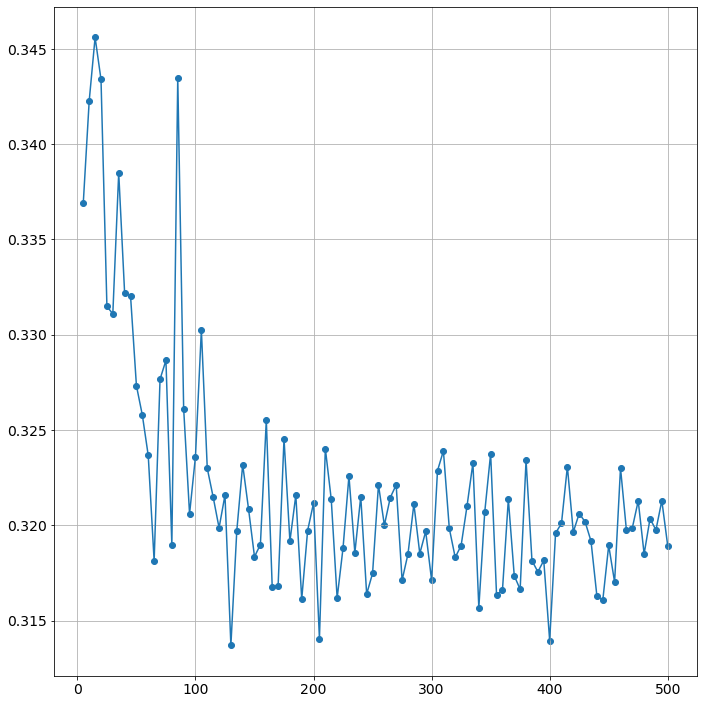

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(co_value['Num Topic'], co_value['c_v'])
plt.scatter(co_value['Num Topic'], co_value['c_v'])
plt.ylim(0.30, 0.35)
#plt.xticks(np.arange(5, 505, 5), rotation=90)
plt.grid()
plt.tight_layout()
plt.show()